MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
The number of classes is: 2 
 The number of channels is 1.
The class_names are {'0': 'normal', '1': 'pneumonia'}
{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'task': 'binary-class', 'label': {'0': 'normal', '1': 'pneumonia'}, 'n_channels': 1, 'n_samples': {'train': 4708, 'val': 524, 'test': 624}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: /home/givasile/.medmnist/pne

/home/givasile/github/MSc-thesis/chrysoula-theodora/MSc_Thesis/env/lib/python3.9/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


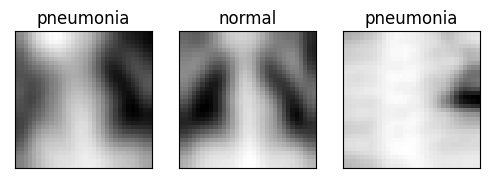

In [10]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

from ConvNet import ConvNet
from Model_LeNet import LeNet


from dataset import train_dataset, test_dataset, train_loader, test_loader, task, n_channels, n_classes

In [11]:
epochs = 30
lr = 0.001
num_workers = 2

In [12]:
ConvNet(n_channels, n_classes)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MyDropout()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MyDropout()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MyDropout()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): MyDropout()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [13]:
def save_model(model):
    '''
    Function to save the trained model 
    '''
   
    if model.__class__.__name__ == 'LeNet':
        torch.save(model.state_dict(), '../outputs/pneumonia_lenet.ckpt')
    else:
        torch.save(model.state_dict(), '../outputs/pneumonia_convnet.ckpt')
        

In [14]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0.0
    counter = 0
    for i, (image, labels) in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        #image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(image)
        
        # Calculate the loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)
            
        train_running_loss += loss.item()
        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds==labels).sum().item()
        # Backpropagation
        loss.backward()
        #Update teh weights
        optimizer.step()
        
    # Loss and accuracy for the complete epoch
    epoch_loss = train_running_loss/counter
    epoch_acc = 100.*(train_running_correct/ len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [15]:
if __name__ == '__main__':
    # Criterion
    if task == 'multi-label, binary-class':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
        
    # model selection
    model = ConvNet(n_channels, n_classes)  # LeNet accyracy: 89.075
    print(model.__class__.__name__ )
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr, momentum = 0.9)
    
    # Lists to keep track of losses and accuracies
    train_loss = []
    train_acc = []
    # Starting the training
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        
        print(f"Training Loss: {train_epoch_loss:.3f}, training_acc: {train_epoch_acc:.3f}")
        print ('='*50)
        
    #Save the trained model weights
    save_model(model)

ConvNet
[INFO]: Epoch 1 of 30
Training


  0%|                                                                                                                                                                                    | 0/148 [00:00<?, ?it/s]/home/givasile/github/MSc-thesis/chrysoula-theodora/MSc_Thesis/env/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 39.70it/s]

Training Loss: 0.614, training_acc: 70.285
[INFO]: Epoch 2 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 40.22it/s]

Training Loss: 0.580, training_acc: 74.214
[INFO]: Epoch 3 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 39.07it/s]

Training Loss: 0.569, training_acc: 74.214
[INFO]: Epoch 4 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 39.45it/s]

Training Loss: 0.563, training_acc: 74.214
[INFO]: Epoch 5 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.95it/s]

Training Loss: 0.550, training_acc: 74.214
[INFO]: Epoch 6 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.53it/s]

Training Loss: 0.522, training_acc: 74.554
[INFO]: Epoch 7 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.78it/s]

Training Loss: 0.473, training_acc: 77.528
[INFO]: Epoch 8 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.40it/s]

Training Loss: 0.422, training_acc: 80.629
[INFO]: Epoch 9 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.32it/s]

Training Loss: 0.370, training_acc: 84.155
[INFO]: Epoch 10 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.21it/s]

Training Loss: 0.348, training_acc: 85.259
[INFO]: Epoch 11 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.04it/s]

Training Loss: 0.320, training_acc: 85.896
[INFO]: Epoch 12 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 35.19it/s]

Training Loss: 0.296, training_acc: 87.213
[INFO]: Epoch 13 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 33.33it/s]

Training Loss: 0.290, training_acc: 88.615
[INFO]: Epoch 14 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 33.90it/s]

Training Loss: 0.277, training_acc: 89.125
[INFO]: Epoch 15 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 34.31it/s]

Training Loss: 0.276, training_acc: 88.679
[INFO]: Epoch 16 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 36.82it/s]

Training Loss: 0.271, training_acc: 89.295
[INFO]: Epoch 17 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.26it/s]

Training Loss: 0.245, training_acc: 90.633
[INFO]: Epoch 18 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.93it/s]

Training Loss: 0.250, training_acc: 90.251
[INFO]: Epoch 19 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 36.01it/s]

Training Loss: 0.238, training_acc: 91.228
[INFO]: Epoch 20 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 36.41it/s]

Training Loss: 0.227, training_acc: 91.206
[INFO]: Epoch 21 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.67it/s]

Training Loss: 0.235, training_acc: 90.952
[INFO]: Epoch 22 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.46it/s]

Training Loss: 0.231, training_acc: 90.845
[INFO]: Epoch 23 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 37.68it/s]

Training Loss: 0.226, training_acc: 91.334
[INFO]: Epoch 24 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:03<00:00, 38.22it/s]

Training Loss: 0.210, training_acc: 91.228
[INFO]: Epoch 25 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 34.39it/s]

Training Loss: 0.217, training_acc: 91.249
[INFO]: Epoch 26 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 35.15it/s]

Training Loss: 0.207, training_acc: 91.992
[INFO]: Epoch 27 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 35.25it/s]

Training Loss: 0.215, training_acc: 91.674
[INFO]: Epoch 28 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 34.38it/s]

Training Loss: 0.210, training_acc: 91.695
[INFO]: Epoch 29 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 34.56it/s]

Training Loss: 0.208, training_acc: 92.077
[INFO]: Epoch 30 of 30
Training



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:04<00:00, 34.23it/s]

Training Loss: 0.205, training_acc: 92.396
